In [1]:
from __future__ import annotations

import argparse
import math
import os
import random
import socket
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm

import config as config
from sp_eyegan.preprocessing import data_loader as data_loader
from sp_eyegan.preprocessing import event_detection as event_detection
from sp_eyegan.preprocessing import smoothing as smoothing
from sp_eyegan.model import eventGAN as eventGAN

In [2]:
def get_scanpath_of_single_file(fixation_list):
    scanpath = []
    for i in range(len(fixation_list)):
        frame_no = fixation_list[i][0][6]
        # x_dva_sum = np.sum(fixation_list[i][:, 0])
        # y_dva_sum = np.sum(fixation_list[i][:, 1])
        #
        # x_dva_avg = x_dva_sum / len(fixation_list[i])
        # y_dva_avg = y_dva_sum / len(fixation_list[i])
        # scanpath.append([int(frame_no), x_dva_avg, y_dva_avg])
        scanpath.append([int(frame_no), fixation_list[i][5][0], fixation_list[i][5][1]])

    return np.array(scanpath)


def dva_to_vel(vector):
    vel = np.array(vector[1:]) - np.array(vector[0:-1])
    vel = np.array([0] + list(vel))
    return vel


def total_velocity_magnitude(vel_x, vel_y):
    vel_x_squared = vel_x ** 2
    vel_y_squared = vel_y ** 2
    magnitude_squared = vel_x_squared + vel_y_squared
    magnitude = np.sqrt(magnitude_squared)
    return magnitude

def ScreenCoord2AngularCoord(ScreenCoord):
    # Inverse transformation of screen coords (0-1) to angular coords (degrees).

    # Parameters of the Hmd (HTC Vive).
    # Vertical FOV.
    VerticalFov = math.pi * 110 / 180
    # Size of a half screen.
    ScreenWidth = 1080
    ScreenHeight = 1200
    # The pixel distance between the eye and the screen center.
    ScreenDist = 0.5 * ScreenHeight / math.tan(VerticalFov / 2)

    AngularCoord = np.zeros(2)

    # The X coord.
    AngularCoord[0] = (math.atan((ScreenCoord[0] - 0.5) * ScreenWidth / ScreenDist) * 180) / math.pi
    # The Y coord.
    AngularCoord[1] = (math.atan((ScreenCoord[1] - 0.5) * ScreenHeight / ScreenDist) * 180) / math.pi

    return AngularCoord

giw_x_vals len 14997
(100,)
(100,)
(100,)


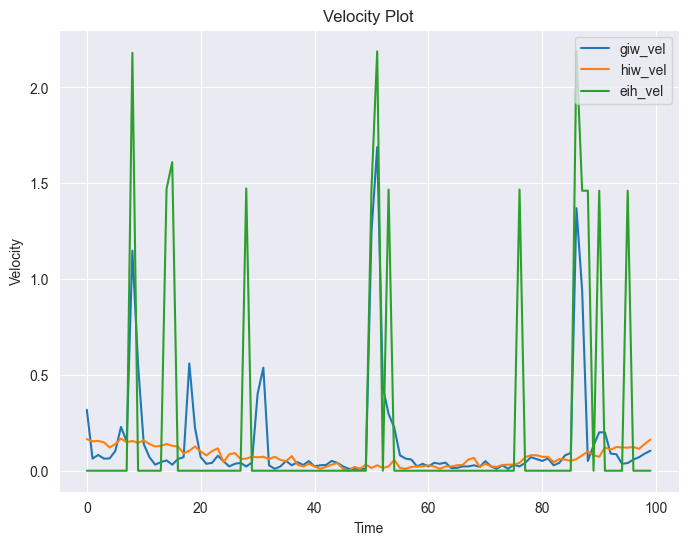

In [6]:
data_path = '../data/EHTaskDataset/RawData/User_01_Video_01_Task_1.txt'

giw_x_vals = []
giw_y_vals = []
hiw_x_vals = []
hiw_y_vals = []
eih_x_vals = []
eih_y_vals = []

with open(data_path, 'r') as file:
    for line in file:
        values = line.split()

        giw_x_vals.append(float(values[6]))
        giw_y_vals.append(float(values[7]))

        hiw_x_vals.append(float(values[2]))
        hiw_y_vals.append(float(values[3]))

        eih_dvas = ScreenCoord2AngularCoord([float(values[4]), float(values[5])])

        eih_x_vals.append(eih_dvas[0])
        eih_y_vals.append(eih_dvas[1])

# index1 = [i for i, x in enumerate(giw_x_vals) if x == x_dva[100]]
# index2 = [i for i, x in enumerate(giw_x_vals) if x == x_dva[101]]
# 
# if len(index1) == 0:
#     raise "index1 not found"
# if len(index2) == 0:
#     raise "index2 not found"
# 
# print(index1)
# print(index2)
# 
# giw_x_vals = giw_x_vals[index1[0]:index2[0] + 1]
# giw_y_vals = giw_y_vals[index1[0]:index2[0] + 1]
# hiw_x_vals = hiw_x_vals[index1[0]:index2[0] + 1]
# hiw_y_vals = hiw_y_vals[index1[0]:index2[0] + 1]
# eih_x_vals = eih_x_vals[index1[0]:index2[0] + 1]
# eih_y_vals = eih_y_vals[index1[0]:index2[0] + 1]
# 
# print('x_vals len', len(x_vals))
print('giw_x_vals len', len(giw_x_vals))

# x_vel = dva_to_vel(np.array(x_vals))
# y_vel = dva_to_vel(np.array(y_vals))
giw_x_vel = dva_to_vel(np.array(giw_x_vals))
giw_y_vel = dva_to_vel(np.array(giw_y_vals))
hiw_x_vel = dva_to_vel(np.array(hiw_x_vals))
hiw_y_vel = dva_to_vel(np.array(hiw_y_vals))
eih_x_vel = dva_to_vel(np.array(eih_x_vals))
eih_y_vel = dva_to_vel(np.array(eih_y_vals))

# target_vel = total_velocity_magnitude(x_vel, y_vel)
giw_vel = total_velocity_magnitude(giw_x_vel, giw_y_vel)
hiw_vel = total_velocity_magnitude(hiw_x_vel, hiw_y_vel)
eih_vel = total_velocity_magnitude(eih_x_vel, eih_y_vel)

giw_vel = giw_vel[1000:2000]
hiw_vel = hiw_vel[1000:2000]
eih_vel = eih_vel[1000:2000]

giw_vel = giw_vel[100:200]
hiw_vel = hiw_vel[100:200]
eih_vel = eih_vel[100:200]

# print(target_vel.shape)
print(giw_vel.shape)
print(hiw_vel.shape)
print(eih_vel.shape)

time = np.linspace(0, 10, 100)  # Sample time values
# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size
# plt.plot(range(len(target_vel)), target_vel, label='target_vel')
plt.plot(range(len(giw_vel)), giw_vel, label='giw_vel')
plt.plot(range(len(hiw_vel)), hiw_vel, label='hiw_vel')
plt.plot(range(len(eih_vel)), eih_vel, label='eih_vel')

# Set plot title and labels
plt.title('Velocity Plot')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()  # Show legend

# Save the plot as a PNG file
# plt.savefig('velocity_plot.png')

# Show the plot (optional)
plt.show()